In [46]:
# Labirinto modificado com geração dinâmica

from typing import Iterable, Tuple, Dict, List
from collections import deque
from time import perf_counter
import matplotlib.pyplot as plt
from random import randint
import random
import tracemalloc as tm
import gc


# ==============================
# GERAÇÃO DINÂMICA DO LABIRINTO
# ==============================

def gerar_labirinto(linhas: int, colunas: int) -> List[List[str]]:
    """Gera dinamicamente um labirinto de tamanho (linhas x colunas)
    utilizando algoritmo de backtracking recursivo.
    Retorna uma matriz contendo:
        '.' = Caminho livre
        '#' = Parede
        'S' = Início
        'G' = Objetivo
    """

    # Garante que as dimensões sejam ímpares
    if linhas % 2 == 0:
        linhas += 1
    if colunas % 2 == 0:
        colunas += 1

    # Inicializa grid preenchido com paredes
    labirinto = [['#' for _ in range(colunas)] for _ in range(linhas)]

    # Direções possíveis (movimento de duas células)
    direcoes = [(-2, 0), (0, 2), (2, 0), (0, -2)]

    def dentro_do_labirinto(x: int, y: int) -> bool:
        """Verifica se a posição está dentro dos limites internos."""
        return 0 < x < linhas - 1 and 0 < y < colunas - 1

    def criar_caminho(x: int, y: int):
        """Cria caminhos recursivamente a partir da posição (x, y)."""
        labirinto[x][y] = '.'
        direcoes_embaralhadas = direcoes.copy()
        random.shuffle(direcoes_embaralhadas)

        for dx, dy in direcoes_embaralhadas:
            nx, ny = x + dx, y + dy
            mx, my = x + dx // 2, y + dy // 2

            if dentro_do_labirinto(nx, ny) and labirinto[nx][ny] == '#':
                labirinto[mx][my] = '.'
                criar_caminho(nx, ny)

    criar_caminho(1, 1)

    labirinto[1][1] = 'S'
    labirinto[linhas - 2][colunas - 2] = 'G'

    return labirinto

# Função auxiliar para exibir o grid
def print_maze(grid):
    """Imprime o labirinto linha por linha."""
    for row in grid:
        print("".join(row))


# ==============================
# GERAÇÃO INICIAL DO LABIRINTO
# ==============================

maze = gerar_labirinto(15, 21)

print("\nLABIRINTO INICIAL GERADO:")
print("=" * len(maze[0]))
print_maze(maze)
print("=" * len(maze[0]))

# Encontrar caractere S e G (Start e Goal)
ROWS, COLS = len(maze), len(maze[0])


def find_char(grid, ch: str) -> Tuple[int, int]:
    """Encontra a primeira ocorrência do caractere `ch` no grid. Retorna (linha, coluna). Levanta ValueError se não encontrado."""
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] == ch:
                return (r, c)
    raise ValueError(f"Caractere {ch} não encontrado.")


start = find_char(maze, "S")
goal = find_char(maze, "G")

print(f"\nStart: {start}")
print(f"Goal: {goal}")


LABIRINTO INICIAL GERADO:
#####################
#S..#.........#.....#
###.#####.###.#####.#
#...#.....#.#...#...#
#.###.#####.###.#.#.#
#...#...#.....#...#.#
###.###.#.#########.#
#.#.#...#.......#...#
#.#.#.###.###.#.#.###
#...#.#.#.#...#.#.#.#
#.###.#.#.#.#####.#.#
#.....#...#.....#.#.#
#######.#######.#.#.#
#.............#....G#
#####################

Start: (1, 1)
Goal: (13, 19)


BFS: 0.0003133 segundos
DFS: 0.0002938 segundos


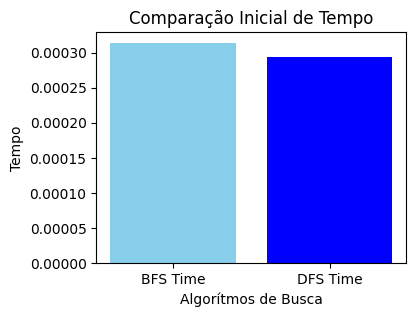

In [47]:
# Obter todos os estados
def neighbors(pos: Tuple[int, int], grid) -> Iterable[Tuple[int, int]]:
    """Retorna todos os vizinhos válidos (cima, baixo, esquerda, direita e diagonais) dentro dos limites e não bloqueados por parede."""
    r, c = pos
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, -1), (-1, 1), (1, 1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < len(grid) and 0 <= nc < len(grid[0]):
            if grid[nr][nc] != '#':
                yield (nr, nc)


list(neighbors(start, maze))


# Reconstruir caminho no grid
def reconstruct_path_grid(parent: Dict[Tuple[int, int], Tuple[int, int]], start, goal) -> List[Tuple[int, int]]:
    """Reconstrói o caminho do start ao goal usando o mapa de pais."""
    if goal not in parent and goal != start:
        return []
    path = [goal]
    cur = goal
    while cur != start:
        cur = parent[cur]
        path.append(cur)
    path.reverse()
    return path


# BFS no grid
def bfs_grid(grid, start, goal):
    """Executa busca em largura no grid do start ao goal. Retorna (found: bool, path)."""
    q = deque([start])
    visited = {start}
    parent = {}

    while q:
        u = q.popleft()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        for v in neighbors(u, grid):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                q.append(v)

    return False, []


# DFS no grid
def dfs_grid(grid, start, goal):
    """Executa busca em profundidade no grid do start ao goal. Retorna (found: bool, path)."""
    stack = [start]
    visited = {start}
    parent = {}

    while stack:
        u = stack.pop()
        if u == goal:
            return True, reconstruct_path_grid(parent, start, goal)

        for v in reversed(list(neighbors(u, grid))):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                stack.append(v)

    return False, []


# Aqui foi feito para testar o tempo de execução das funções BFS e DFS e gerar o primeiro gráfico
bfs_time_start = perf_counter()
found_bfs, path_bfs = bfs_grid(maze, start, goal)
bfs_time_end = perf_counter()
bfs_time = bfs_time_end - bfs_time_start

dfs_time_start = perf_counter()
found_dfs, path_dfs = dfs_grid(maze, start, goal)
dfs_time_end = perf_counter()
dfs_time = dfs_time_end - dfs_time_start

print(f'BFS: {bfs_time:.05} segundos')
print(f'DFS: {dfs_time:.05} segundos')

# Melhor grid executado pela última vez
plt.figure(figsize=(4, 3))
plt.bar(['BFS Time', 'DFS Time'], [bfs_time, dfs_time], color=['skyblue', 'blue'])
plt.xlabel('Algorítmos de Busca')
plt.ylabel('Tempo')
plt.title("Comparação Inicial de Tempo")
plt.show()

In [48]:
# ==============================
# FUNÇÕES DE MEDIÇÃO
# ==============================

def get_bfs_time(maze):
    """Mede e retorna o tempo de execução do BFS (em segundos)."""
    bfs_time_start = perf_counter()
    bfs_grid(maze, start, goal)
    bfs_time_end = perf_counter()
    return bfs_time_end - bfs_time_start


def get_dfs_time(maze):
    """Mede e retorna o tempo de execução do DFS (em segundos)."""
    dfs_time_start = perf_counter()
    dfs_grid(maze, start, goal)
    dfs_time_end = perf_counter()
    return dfs_time_end - dfs_time_start


def get_bfs_memory(maze):
    """Mede e retorna o pico de uso de memória do BFS (em KB)."""
    gc.collect()
    tm.start()
    bfs_grid(maze, start, goal)
    current, peak = tm.get_traced_memory()
    peak_kb = peak / 1024
    print(f'KB usados no BFS: {peak_kb} com o labirinto de tamanho {len(maze)}')
    tm.stop()
    return peak_kb


def get_dfs_memory(maze):
    """Mede e retorna o pico de uso de memória do DFS (em KB)."""
    gc.collect()
    tm.start()
    dfs_grid(maze, start, goal)
    current, peak = tm.get_traced_memory()
    peak_kb = peak / 1024
    print(f'KB usados no DFS: {peak_kb} com o labirinto de tamanho {len(maze)}')
    tm.stop()
    return peak_kb


# Aqui a lógica para gerar os gráficos de comparação de desempenho e memória
bfs_times = []
dfs_times = []
bfs_memory = []
dfs_memory = []

for bigO in range(5):

    maze = gerar_labirinto(25 + bigO * 15, 25 + bigO * 15)
    start = find_char(maze, "S")
    goal = find_char(maze, "G")

    bfs_times.append(get_bfs_time(maze))
    dfs_times.append(get_dfs_time(maze))
    bfs_memory.append(get_bfs_memory(maze))
    dfs_memory.append(get_dfs_memory(maze))


avg_bfs_time = sum(bfs_times) / len(bfs_times)
avg_dfs_time = sum(dfs_times) / len(dfs_times)

avg_bfs_memory = sum(bfs_memory) / len(bfs_memory)
avg_dfs_memory = sum(dfs_memory) / len(dfs_memory)

KB usados no BFS: 24.1015625 com o labirinto de tamanho 25
KB usados no DFS: 38.1171875 com o labirinto de tamanho 25
KB usados no BFS: 33.0 com o labirinto de tamanho 41
KB usados no DFS: 128.40625 com o labirinto de tamanho 41
KB usados no BFS: 137.1484375 com o labirinto de tamanho 55
KB usados no DFS: 268.03125 com o labirinto de tamanho 55
KB usados no BFS: 124.7890625 com o labirinto de tamanho 71
KB usados no DFS: 340.8046875 com o labirinto de tamanho 71
KB usados no BFS: 312.640625 com o labirinto de tamanho 85
KB usados no DFS: 498.5625 com o labirinto de tamanho 85


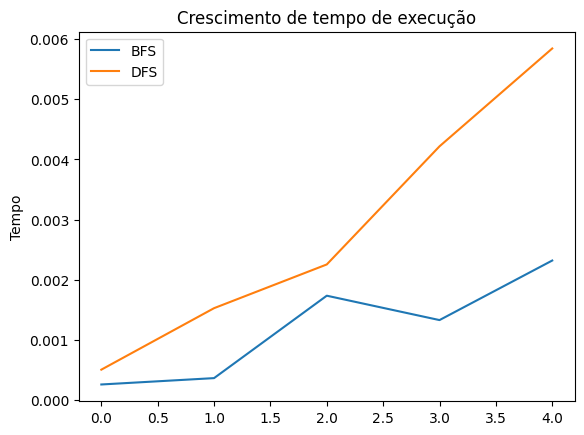

DFS teve um desempenho inferior ao BFS para encontrar o caminho do labirinto
Com a média de 0.0028707999910693614 segundos
Com a diferença média de 0.001667039992753416 segundos.


In [49]:
# Gráficos para comparar tempo de execução BFS vs DFS
plt.plot(bfs_times)
plt.plot(dfs_times)
plt.ylabel("Tempo")
plt.title("Crescimento de tempo de execução")
plt.legend(["BFS", "DFS"])
plt.show()

if max(bfs_times) > max(dfs_times):
    print(f'BFS teve um desempenho inferior ao DFS para encontrar o caminho do labirinto\nCom a média de {avg_bfs_time} segundos\nCom a diferença média de {avg_bfs_time-avg_dfs_time} segundos.')
elif max(dfs_times) > max(bfs_times):
    print(f'DFS teve um desempenho inferior ao BFS para encontrar o caminho do labirinto\nCom a média de {avg_dfs_time} segundos\nCom a diferença média de {avg_dfs_time-avg_bfs_time} segundos.')


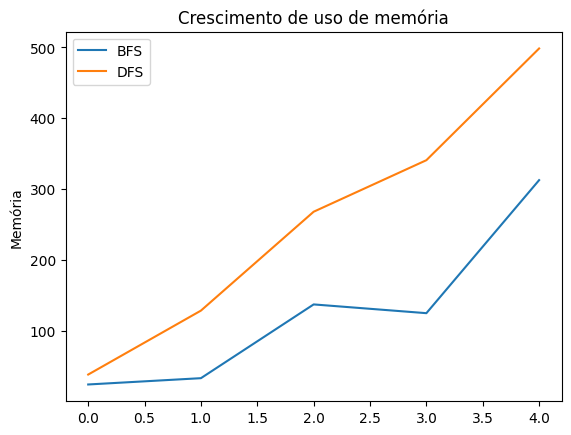

DFS teve um desempenho inferior ao BFS em uso de memória ao executar a função e encontrar os caminhos no labirinto
Com a média de 254.78 bytes
Com a diferença média de 128.45 bytes para mais.


In [50]:
# Gráfico para comparar memória usada em BFS e DFS no grid
plt.plot(bfs_memory)
plt.plot(dfs_memory)
plt.ylabel("Memória")
plt.title("Crescimento de uso de memória")
plt.legend(["BFS", "DFS"])
plt.show()

if avg_bfs_memory > avg_dfs_memory:
    print(f'BFS teve um desempenho inferior ao DFS em uso de memória ao executar a função e encontrar os caminhos no labirinto\nCom a média de {round(avg_bfs_memory, 2)} bytes\nCom a diferença média de {round(avg_bfs_memory-avg_dfs_memory, 2)} bytes para mais.')
elif avg_dfs_memory > avg_bfs_memory:
    print(f'DFS teve um desempenho inferior ao BFS em uso de memória ao executar a função e encontrar os caminhos no labirinto\nCom a média de {round(avg_dfs_memory, 2)} bytes\nCom a diferença média de {round(avg_dfs_memory-avg_bfs_memory, 2)} bytes para mais.')